In [1]:
import pandas as pd
import pickle
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.conferences import Conferences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import poisson
from scipy.optimize import minimize


I am gonna just try to get the following data for 2020-2021 season for NCAA basketball:
```
Date, HomeTeam, AwayTeam, HP, AP
```
Then I am gonna try to reproduce [this analysis](http://www.pena.lt/y/2021/06/18/predicting-football-results-using-the-poisson-distribution/).

Then I will try to recode the analysis in Pyro.

Then I will try to modify it.

Perhaps focus on the second half over under. So I will need the first half and second half totals. 

Some notes on modeling:
- I could just focus on the point spead and use a linear model. 
- I could use a binomial regression; no stick with poisson
- I think I need to try a bunch of simple models and show how easy it is to do in Pyro
- I think I should start with just fitting a poisson to each team
- the good thing about a generative model is that you can calculate outcomes of prop bets such as the outcome of the first half
- I think adding in defense and offense factors into the poisson regression makes sense
- I think training on only away games could also make sense; or including the factor for home or away but then setting it to "away" for the tournament games. The latter makes more sense. I will need a feature for home, one for away, and if they are both off that is a neutral site
- I could move to a hierarchical model with the intercept decided by the conference. So I have a linear relation between the conference
- The model from Pena.lt/y uses a linear combination of offense, defense, and home advantage but exponentiates it and this gives different probabilities. Not sure why they do this.

Some notes on data munging:
- I might want to drop all games where the opponent is not in one of the big conferences (opponent_conference in ...)
- Most games will be listed twice: once for the home team, once for the away team. Thus, I will need to drop one of them for some modeling setups (ie., the boxscore_index needs to be unique).




In [98]:
majorConfs = ["big-12","Big 12",
              "big-10","Big Ten",
              "sec","SEC",
              "big-east","Big East",
              "pac-12","PAC-12",
              "acc","ACC",
              "wcc", "WCC"]
def getDataForTeams(teams) :
    dataset = pd.DataFrame()
    for team in teams:
        if team.conference in majorConfs:
            tgDF = team.schedule.dataframe
            tgDF['team_name'] = team.name
            tgDF['team_conference'] = team.conference
            dataset = pd.concat([dataset,tgDF])     
    return dataset



In [79]:
#execute this cell to grab the data from the site
season_team_list = Teams("2021")
df = getDataForTeams(season_team_list)
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
df.to_csv('data/bigconfs2021Season.zip', compression=compression_opts) 
pickle.dump( season_team_list, open( "data/teams2021.p", "wb" ) )

In [80]:
#execute this cell to just load the local files
season_team_list = pickle.load( open( "data/teams2021.p", "rb" ) )
c_opts = dict(method='zip')
df = pd.read_csv('data/bigconfs2021Season.zip',compression='zip')

In [64]:
#some access functions practice
type(season_team_list)
t = next(iter(season_team_list))
[t.name, t.conference]
game = next(iter(t.schedule))
type(game)

sportsreference.ncaab.schedule.Game

In [100]:
bdf = df
len(bdf)

1872

In [99]:
bdf = df

bdf = bdf[bdf["opponent_conference"].isin(majorConfs)]
len(bdf)

1221

In [102]:
bdf = bdf.drop_duplicates(subset='boxscore_index', keep="first")
len(bdf)

1138

In [105]:
data = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
data.head()

,Unnamed: 0,arena,boxscore_index,date,datetime,game,opponent_abbr,opponent_conference,opponent_name,opponent_rank,...,season_losses,season_wins,streak,time,type,team_name,team_conference,location_Away,location_Home,location_Neutral
0,2020-11-25-20-alabama,Coleman Coliseum,2020-11-25-20-alabama,"Wed, Nov 25, 2020",2020-11-25 20:00:00,1,jacksonville-state,OVC,Jacksonville State,NaN,...,0.0,1.0,W 1,8:00p,Reg,Alabama,sec,0,1,0
1,2020-11-30-21-alabama,U.S. Cellular Center,2020-11-30-21-alabama,"Mon, Nov 30, 2020",2020-11-30 21:30:00,2,stanford,Pac-12,Stanford,NaN,...,1.0,1.0,L 1,9:30p,Reg,Alabama,sec,0,0,1
2,2020-12-01-21-alabama,U.S. Cellular Center,2020-12-01-21-alabama,"Tue, Dec 1, 2020",2020-12-01 21:30:00,3,nevada-las-vegas,MWC,Nevada-Las Vegas,NaN,...,1.0,2.0,W 1,9:30p,Reg,Alabama,sec,0,0,1
3,2020-12-02-19-alabama,U.S. Cellular Center,2020-12-02-19-alabama,"Wed, Dec 2, 2020",2020-12-02 19:00:00,4,providence,Big East,Providence,NaN,...,1.0,3.0,W 2,7:00p,Reg,Alabama,sec,0,0,1
4,2020-12-12-20-alabama,Philips Arena,2020-12-12-20-alabama,"Sat, Dec 12, 2020",2020-12-12 20:00:00,5,clemson,ACC,Clemson,NaN,...,2.0,3.0,L 1,8:00p,Reg,Alabama,sec,0,0,1


In [120]:
bdf = df

bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
bdf.head()

,Unnamed: 0,arena,boxscore_index,date,datetime,game,opponent_abbr,opponent_conference,opponent_name,opponent_rank,...,season_losses,season_wins,streak,time,type,team_name,team_conference,location_Away,location_Home,location_Neutral
0,2020-11-25-20-alabama,Coleman Coliseum,2020-11-25-20-alabama,"Wed, Nov 25, 2020",2020-11-25 20:00:00,1,jacksonville-state,OVC,Jacksonville State,NaN,...,0.0,1.0,W 1,8:00p,Reg,Alabama,sec,0,1,0
1,2020-11-30-21-alabama,U.S. Cellular Center,2020-11-30-21-alabama,"Mon, Nov 30, 2020",2020-11-30 21:30:00,2,stanford,Pac-12,Stanford,NaN,...,1.0,1.0,L 1,9:30p,Reg,Alabama,sec,0,0,1
2,2020-12-01-21-alabama,U.S. Cellular Center,2020-12-01-21-alabama,"Tue, Dec 1, 2020",2020-12-01 21:30:00,3,nevada-las-vegas,MWC,Nevada-Las Vegas,NaN,...,1.0,2.0,W 1,9:30p,Reg,Alabama,sec,0,0,1
3,2020-12-02-19-alabama,U.S. Cellular Center,2020-12-02-19-alabama,"Wed, Dec 2, 2020",2020-12-02 19:00:00,4,providence,Big East,Providence,NaN,...,1.0,3.0,W 2,7:00p,Reg,Alabama,sec,0,0,1
4,2020-12-12-20-alabama,Philips Arena,2020-12-12-20-alabama,"Sat, Dec 12, 2020",2020-12-12 20:00:00,5,clemson,ACC,Clemson,NaN,...,2.0,3.0,L 1,8:00p,Reg,Alabama,sec,0,0,1


In [122]:
bdf = df
#only have games between big conferences
bdf = bdf[bdf["opponent_conference"].isin(majorConfs)]
#get rid of duplicates
bdf.drop_duplicates(subset='boxscore_index', keep="first")
#drop Neutral games for now
bdf = bdf[bdf["location"].isin(["Home","Away"])]
#create Home, Away, neutral indicator columns
bdf = pd.get_dummies(bdf,prefix=['location'], columns = ['location'])
#create homeTeam, awayTeam columns
def addHomeTeamColumn(row):
    if(row['location_Home'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['HomeTeam'] = bdf.apply(addHomeTeamColumn, axis=1)
def addAwayTeamColumn(row):
    if(row['location_Away'] == 1):
        return row['team_name']
    else:
        return row['opponent_name']
bdf['AwayTeam'] = bdf.apply(addAwayTeamColumn, axis=1)
#add in "HomePoints" , AwayPoints
def addHomePointsColumn(row):
    if(row['location_Home'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['HomePoints'] = bdf.apply(addHomePointsColumn, axis=1)
def addAwayPointsColumn(row):
    if(row['location_Away'] == 1):
        return row['points_for']
    else:
        return row['points_against']
bdf['AwayPoints'] = bdf.apply(addAwayPointsColumn, axis=1)
#rename columns
selector_d = {'date':'Date', 'HomeTeam':'HomeTeam', 'AwayTeam':'AwayTeam',
              'HomePoints':'FTHG', 'AwayPoints':'FTAG'}
bdf = bdf.rename(columns=selector_d)[selector_d.values()]
bdf.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
8,"Tue, Dec 29, 2020",Alabama,Mississippi,82.0,64.0
9,"Sat, Jan 2, 2021",Tennessee,Alabama,63.0,71.0
10,"Tue, Jan 5, 2021",Alabama,Florida,86.0,71.0
11,"Sat, Jan 9, 2021",Auburn,Alabama,90.0,94.0
12,"Tue, Jan 12, 2021",Kentucky,Alabama,65.0,85.0


In [126]:
df.iloc[[8]]

,Unnamed: 0,arena,boxscore_index,date,datetime,game,location,opponent_abbr,opponent_conference,opponent_name,...,points_against,points_for,result,season_losses,season_wins,streak,time,type,team_name,team_conference
8,2020-12-29-21-alabama,Coleman Coliseum,2020-12-29-21-alabama,"Tue, Dec 29, 2020",2020-12-29 21:00:00,9,Home,mississippi,SEC,Mississippi,...,64.0,82.0,Win,3.0,6.0,W 2,9:00p,Reg,Alabama,sec


In [7]:
df.loc[df['team_name'] == 'Alabama']

,Unnamed: 0,arena,boxscore_index,date,datetime,game,location,opponent_abbr,opponent_conference,opponent_name,...,points_against,points_for,result,season_losses,season_wins,streak,time,type,team_name,team_conference
0,2020-11-25-20-alabama,Coleman Coliseum,2020-11-25-20-alabama,"Wed, Nov 25, 2020",2020-11-25 20:00:00,1,Home,jacksonville-state,OVC,Jacksonville State,...,57.0,81.0,Win,0.0,1.0,W 1,8:00p,Reg,Alabama,sec
1,2020-11-30-21-alabama,U.S. Cellular Center,2020-11-30-21-alabama,"Mon, Nov 30, 2020",2020-11-30 21:30:00,2,Neutral,stanford,Pac-12,Stanford,...,82.0,64.0,Loss,1.0,1.0,L 1,9:30p,Reg,Alabama,sec
2,2020-12-01-21-alabama,U.S. Cellular Center,2020-12-01-21-alabama,"Tue, Dec 1, 2020",2020-12-01 21:30:00,3,Neutral,nevada-las-vegas,MWC,Nevada-Las Vegas,...,74.0,86.0,Win,1.0,2.0,W 1,9:30p,Reg,Alabama,sec
3,2020-12-02-19-alabama,U.S. Cellular Center,2020-12-02-19-alabama,"Wed, Dec 2, 2020",2020-12-02 19:00:00,4,Neutral,providence,Big East,Providence,...,71.0,88.0,Win,1.0,3.0,W 2,7:00p,Reg,Alabama,sec
4,2020-12-12-20-alabama,Philips Arena,2020-12-12-20-alabama,"Sat, Dec 12, 2020",2020-12-12 20:00:00,5,Neutral,clemson,ACC,Clemson,...,64.0,56.0,Loss,2.0,3.0,L 1,8:00p,Reg,Alabama,sec
5,2020-12-15-21-alabama,Coleman Coliseum,2020-12-15-21-alabama,"Tue, Dec 15, 2020",2020-12-15 21:00:00,6,Home,furman,Southern,Furman,...,80.0,83.0,Win,2.0,4.0,W 1,9:00p,Reg,Alabama,sec
6,2020-12-19-14-alabama,Coleman Coliseum,2020-12-19-14-alabama,"Sat, Dec 19, 2020",2020-12-19 14:00:00,7,Home,western-kentucky,CUSA,Western Kentucky,...,73.0,71.0,Loss,3.0,4.0,L 1,2:00p,Reg,Alabama,sec
7,2020-12-22-19-alabama,Coleman Coliseum,2020-12-22-19-alabama,"Tue, Dec 22, 2020",2020-12-22 19:30:00,8,Home,east-tennessee-state,Southern,East Tennessee State,...,69.0,85.0,Win,3.0,5.0,W 1,7:30p,Reg,Alabama,sec
8,2020-12-29-21-alabama,Coleman Coliseum,2020-12-29-21-alabama,"Tue, Dec 29, 2020",2020-12-29 21:00:00,9,Home,mississippi,SEC,Mississippi,...,64.0,82.0,Win,3.0,6.0,W 2,9:00p,Reg,Alabama,sec
9,2021-01-02-18-tennessee,Thompson-Boling Arena,2021-01-02-18-tennessee,"Sat, Jan 2, 2021",2021-01-02 18:00:00,10,Away,tennessee,SEC,Tennessee,...,63.0,71.0,Win,3.0,7.0,W 3,6:00p,Reg,Alabama,sec


In [7]:
homeMean = df[df.location=='Home']['points_for'].mean()
awayMean = df[df.location=='Away']['points_for'].mean()
[homeMean,awayMean]

[74.49215246636771, 70.08408408408408]

In [8]:
df[df.location=='Home']['points_for'].max()

142.0

Text(0.5, 1.0, 'Number of Points Scored Per Game')

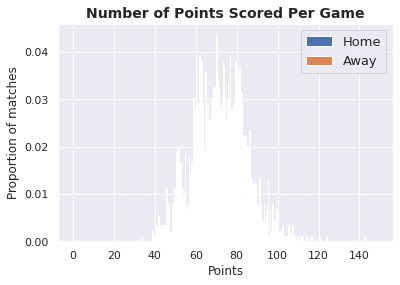

In [9]:

sns.set()

max_goals = 150
homeAwayPtsArray = df[df.location=='Home'][['points_for','points_against']].values
plt.hist(homeAwayPtsArray, range(max_goals), label=["Home", "Away"], density=True
)
#plt.xticks([i - 0.5 for i in range(max_goals)], [i for i in range(max_goals)])
plt.xlabel("Points")
plt.ylabel("Proportion of matches")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Points Scored Per Game", size=14, fontweight="bold")

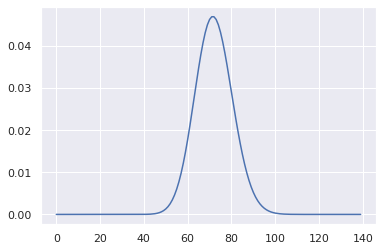

In [10]:
# importing poisson from scipy
from scipy.stats import poisson
 
# importing numpy as np
import numpy as np
 
# importing matplotlib as plt
import matplotlib.pyplot as plt
 
 
# creating a numpy array for x-axis
# using step size as 1
x = np.arange(0, 140, 1)
 
# poisson distribution data for y-axis
y = poisson.pmf(x, mu=72, loc=0)
 
 
# plotting the graph
plt.plot(x, y)
 
# showing the graph
plt.show()

Text(0.5, 1.0, 'Number of Points Scored Per Game')

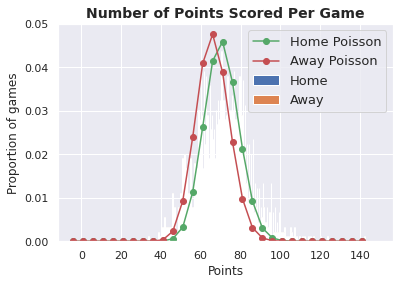

In [11]:

home_poisson = poisson.pmf(range(0,max_goals,5), homeMean)
away_poisson = poisson.pmf(range(0,max_goals,5), awayMean)

plt.hist(
    homeAwayPtsArray, range(max_goals), label=["Home", "Away"], density=True
)

pts = [i - 5 for i in range(1, max_goals + 1,5)]
plt.plot(
    pts,
    home_poisson,
    linestyle="-",
    marker="o",
    label="Home Poisson",
)

plt.plot(
    pts,
    away_poisson,
    linestyle="-",
    marker="o",
    label="Away Poisson",
)


#plt.xticks([i - 0.5 for i in range(1, max_goals + 1)], [i for i in range(max_goals)])
plt.xlabel("Points")
plt.ylabel("Proportion of games")
plt.legend(loc="upper right", fontsize=13)
plt.title("Number of Points Scored Per Game", size=14, fontweight="bold")


In [27]:
#this is data for soccer
#df = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/E0.csv")
#df[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]].head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,11/08/2017,Arsenal,Leicester,4,3
1,12/08/2017,Brighton,Man City,0,2
2,12/08/2017,Chelsea,Burnley,2,3
3,12/08/2017,Crystal Palace,Huddersfield,0,3
4,12/08/2017,Everton,Stoke,1,0


In [130]:
#this is the log likelihood of the first two things happening
def log_likelihood(
    goals_home_observed, #will serve as k
    goals_away_observed, #will serve as k
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
):
    #these will serve as mu
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)
    #goal_expectation_home = home_attack + away_defence + home_advantage
    #goal_expectation_away = away_attack + home_defence

    if goal_expectation_home < 0 or goal_expectation_away < 0:
        return 10000    
    #(k,mu)
    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)

    #probability of both teams' scores
    log_llk = np.log(home_llk) + np.log(away_llk)

    return -log_llk

def predict(home_team, away_team, params, max_goals=10):
    home_attack = params["attack_" + home_team]
    home_defence = params["defence_" + home_team]
    away_attack = params["attack_" + away_team]
    away_defence = params["defence_" + away_team]
    home_advantage = params["home_adv"]

    home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
    away_goal_expectation = np.exp(away_attack + home_defence)
    #home_goal_expectation = home_attack + away_defence + home_advantage
    #away_goal_expectation = away_attack + home_defence

    home_probs = poisson.pmf(list(range(max_goals + 1)), home_goal_expectation)
    away_probs = poisson.pmf(range(max_goals + 1), away_goal_expectation)

    probability_matrix = np.outer(home_probs, away_probs)

    return probability_matrix

In [131]:
    teams = np.sort(np.unique(np.concatenate([bdf["HomeTeam"], bdf["AwayTeam"]])))
    n_teams = len(teams)
    n_teams

80

In [134]:


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([bdf["HomeTeam"], bdf["AwayTeam"]])))
    n_teams = len(teams)

    params = np.concatenate(
        (
            np.random.uniform(2, 25, (n_teams)),  # attack strength
            np.random.uniform(0, -20, (n_teams)),  # defence strength
            [4],  # home advantage
        )
    )

    def _fit(params, bdf, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-1]

        llk = list()
        for idx, row in bdf.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(bdf, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv"],
            res["x"],
        )
    )

    return model_params


In [ ]:
model_params = fit_poisson_model()

<ipython-input-130-5cbeff422d04>:24: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk)
/usr/local/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [ ]:
model_params

In [55]:
probs = predict("Man City", "Stoke", model_params, 4)
print(probs)

[[2.99388228e-02 4.73370595e-03 3.74229344e-04 1.97234617e-05
  7.79632090e-07]
 [1.00309624e-01 1.58602183e-02 1.25385040e-03 6.60831939e-05
  2.61214686e-06]
 [1.68043026e-01 2.65697244e-02 2.10050447e-03 1.10705428e-04
  4.37598152e-06]
 [1.87675301e-01 2.96738351e-02 2.34590403e-03 1.23639017e-04
  4.88722247e-06]
 [1.57200895e-01 2.48554467e-02 1.96498000e-03 1.03562717e-04
  4.09364334e-06]]


In [56]:
#draw
np.sum(np.diag(probs))

0.04802727824610091

In [59]:
#home win
np.sum(np.tril(probs, -1))

0.6987422996925603

In [60]:
# away win
np.sum(np.triu(probs, 1))

0.006570952759483362